In [33]:
import numpy as np
import pandas as pd
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import math
%matplotlib inline
numpy.random.seed(1239)

In [2]:
# Read the data
# Source: https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/
raw_data = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
#Check if any is nan. 
raw_data.isna().sum().sum()

0

In [4]:
def prepare_data(raw_data):
    labels = raw_data.Attrition == 'Yes'
    employee_data = raw_data.set_index('EmployeeNumber').drop(columns=['Attrition', 'EmployeeCount', 'Over18'])
    employee_data.loc[:, 'OverTime'] = employee_data.OverTime == 'Yes'
    employee_data = pd.get_dummies(employee_data)
    employee_data = pd.concat([employee_data.YearsAtCompany, employee_data.drop(columns='YearsAtCompany')], axis=1)
    return employee_data, labels


In [5]:
employee_data, labels = prepare_data(raw_data)
employee_data.OverTime = employee_data.OverTime.astype('float')
employee_data


,YearsAtCompany,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,6,41,1102,1,2,2,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
2,10,49,279,8,1,3,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
4,0,37,1373,2,2,4,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
5,8,33,1392,3,4,4,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
7,2,27,591,2,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0
8,7,32,1005,2,2,4,79,3,1,4,...,1,0,0,0,0,0,0,0,0,1
10,1,59,1324,3,3,3,81,4,1,1,...,1,0,0,0,0,0,0,0,1,0
11,1,30,1358,24,1,4,67,3,1,3,...,1,0,0,0,0,0,0,1,0,0
12,9,38,216,23,3,4,44,2,3,3,...,0,0,1,0,0,0,0,0,0,1


In [6]:
#Now scale the dataset
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(employee_data.values.astype('float')), columns=employee_data.columns)
years_scaler = StandardScaler()
years_scaler.fit(employee_data.YearsAtCompany.values.astype('float').reshape(employee_data.values.shape[0],1));


Now we want to generate synthetic labels to test if our models works in a controlled environment. Let's assume, that the probability that a person quits is a constant and does not depend on any features. In this case the likelihood that the person has quit follows a geometric distribution. If our model can correctly find this probability *p* based on a synthetic labels, then we can try this model on real data. 

In [7]:
#pick a p
p = 0.1

In [80]:
#There is a bug here somewhere. For some reason the synthetic data that we generate result in a much lower parameter
#than originally set (0.1)
def quit_after(years, p):
    '''
    Returns the likelihood that the person quits after the given number of years
    years -- nunber of years
    p -- probability that the person quits in a given year
    '''
    return numpy.random.rand(years.shape[0]) < p*(1-p)**years
    #geometric_sample = numpy.random.geometric(p, years.shape[0])
    #return  geometric_sample years+1

In [81]:
synthetic_labels = quit_after(employee_data.YearsAtCompany, p).astype('float')

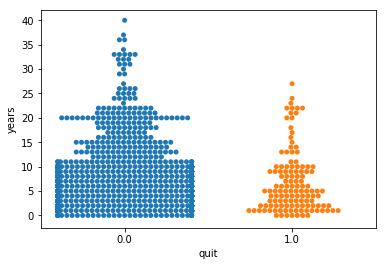

In [82]:
sns.swarmplot(y='years', x='quit', data=pd.DataFrame({"quit":synthetic_labels, 'years':employee_data.YearsAtCompany}))

Based on the chart it seems like a realistic data set.
Now we need to construct our loss function. It will have an additional parameter: number of years

We define probability $p(x, t)$ that the person quits this very day, where t is the number of years and x is the remaining features. Then the likelihood that the person has quit after the year $t$  is 
$$P(x,t) = (\prod_{l=0}^{t-1} (1-p(x,l))) p(x,t) $$ whereas the likelihood that the person will remain after the year $t$ is 
$$P(x,t) = \prod_{l=0}^{t} (1-p(x,l)) $$
Strictly speaking x is also dependent on t, but we don't have the historical data for this, so we assume that x is independent of t.

Using the principle of maximum likelihood, we derive the loss function taking negative log of the likelihood function:
$$\mathscr{L}(y,p) = -\sum_{l=0}^{t-1} \log(1-p(x,l)) - y \log{p} - (1-y) \log(1-p) $$
Where y is an indicator if the person has quit after working exactly t years or not.
Notice that the last two terms is the cross-entropy loss function, and the first term is a hitorical term. 

Let's calculate the gradient of this function
$$ \frac{\partial \mathscr L}{\partial p} = \sum_{l=0}^{t-1} \frac{1}{1-p(x,l)} -\frac{y}{p} + \frac{1-y}{1-p}$$

Assuming that $p(x,l)$ is a sigmoid function (for simplicity we include bias in the list of weights, and so the weight for the t parameter): $$p=\frac{1}{1 + e^{-\bf{w}\bf{x}}}$$
Then the derivative over parameter becomes  for the x other than t:
$$ \frac{\partial \mathscr L}{\partial w_i} = (\sum_{l=0}^{t-1} p(x,l) + p - y) * x_i $$
The gradient for the weight corresponding to t is
$$ \frac{\partial \mathscr L}{\partial w_t} = \sum_{l=0}^{t-1} p(x,l)l + (p - y) * t $$




In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
#Add 1 to the employee data
scaled_data['Ones'] = np.ones(shape=[employee_data.shape[0],1])

In [13]:
def scale_year(years):
    return float(years_scaler.transform(float(years)))

In [14]:
def logit(x, w, years=None):
    '''
    If years is not given, then this is just a dot product of x and w
    If years is given, we have to adjust it to make sure the weight is multiplied by the current year, 
        not the final year
    
    IMPORTANT: This assumes that the weight for the temporal variable is w[0]
    TODO: Remove this assumption and allow to specify the index of the temporal variable
    '''
    return x @ w + ((scale_year(years)-x[0]) * w[0] if years != None else 0)

In [29]:
def loss(x, y, w, years):
    '''
    The loss function
    '''
    #The first term
    sum_loss = 0
    for l in np.arange(years):
        sum_loss -= np.log(1-sigmoid(logit(x, w, l)))
    logistic_prob = sigmoid(logit(x, w))
    return sum_loss - y * np.log(logistic_prob) - (1-y) * np.log(1-logistic_prob)

In [16]:
def gradient(x,y,w, years):
    'The gradient'
    sum_prop = 0
    weighted_sum = 0
    for l in np.arange(years):
        sum_prop += sigmoid(logit(x, w, l)) 
        weighted_sum += sigmoid(logit(x, w, l)) * scale_year(l)
    grad =  (sum_prop + sigmoid(logit(x, w)) - y) * x
    grad[0] = weighted_sum + (sigmoid(logit(x, w)) - y) * x[0]
    return grad
    

In [17]:
def one_pass(weights, step_size, feature_data, temporal_data, labels, l2_regularization):
    '''
    One pass of the gradient descent
    '''
    cost = 0
    num_examples = feature_data.shape[0]
    total_gradient = np.zeros(shape=feature_data.shape[1])
    for i in range(feature_data.shape[0]):
        cost += loss(feature_data.values[i], labels.values[i], weights, temporal_data.iloc[i])  / num_examples
        total_gradient += gradient(feature_data.values[i], labels.values[i], weights, temporal_data.iloc[i]) / num_examples
    
    reg_matrix = l2_regularization * np.eye(len(weights))
    reg_matrix[-1,-1] = 0
    
    cost += 1 / 2 *  weights.T @ reg_matrix @ weights
    total_gradient += reg_matrix @ weights
    
    return cost, weights - step_size * total_gradient
        

In [23]:
#Initialize weights
weights = np.zeros(shape=[scaled_data.values.shape[1]])
epochs = 100
step = 0.5
l2 = 0.9
for epoch in range(epochs):
    cost, weights = one_pass(weights, step, scaled_data, employee_data.YearsAtCompany, synthetic_labels, l2)
    if epoch % 10 == 0:
        print('Cost %f' % cost)

Cost 5.550836


KeyboardInterrupt: 

In [ ]:
#We will print the learned weights.
for column_num, column_name in enumerate(employee_data.columns):
    print(f'{column_name}: {weights[column_num]}')

In [71]:
predicted_prob = pd.Series(logit(scaled_data.values, weights))
predicted_prob.describe()

count    1.470000e+03
mean    -7.800000e+00
std      1.172794e-13
min     -7.800000e+00
25%     -7.800000e+00
50%     -7.800000e+00
75%     -7.800000e+00
max     -7.800000e+00
dtype: float64

In [83]:
#We expect this probability based on the synthesized data (but we are getting something else....)
prb = synthetic_labels.sum()/len(synthetic_labels)/employee_data.YearsAtCompany.mean()
prb

0.0122306348281887

In [84]:
expected_weight = -math.log(1/prb -1)
expected_weight

-4.391505378628426

In [37]:
#We test the loss function
weights = np.zeros(shape=[scaled_data.values.shape[1]])
args = np.arange(0, 30, 0.1)
costs = np.zeros(shape=args.shape)
for weight_num in range(args.shape[0]):
    weights[-1] = -args[weight_num]
    cost = 0
    num_examples = employee_data.shape[0]
    for i in range(num_examples):
        cost += loss(scaled_data.values[i], synthetic_labels.values[i], weights, 
                     employee_data.YearsAtCompany.values.astype('float')[i])  / num_examples
    costs[weight_num] = cost

KeyboardInterrupt: 

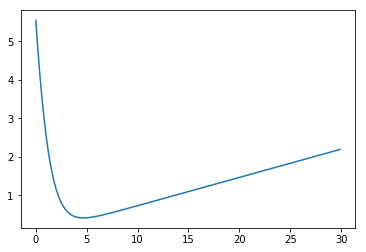

In [26]:
plt.plot(args, costs)

In [51]:
z = np.random.geometric(p=0.35, size=100)
z

array([2, 5, 1, 7, 3, 1, 4, 4, 2, 1, 6, 1, 7, 5, 4, 1, 3, 1, 1, 1, 1, 6,
       1, 1, 2, 2, 1, 3, 4, 1, 2, 1, 1, 1, 2, 1, 1, 2, 6, 3, 4, 3, 4, 2,
       2, 2, 5, 2, 2, 1, 2, 4, 6, 1, 2, 5, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1,
       2, 4, 6, 1, 2, 2, 1, 4, 5, 2, 1, 4, 3, 2, 4, 1, 2, 3, 1, 1, 2, 1,
       2, 1, 3, 5, 1, 1, 2, 2, 3, 2, 7, 3])